# TUTORIAL 1 : Generate an acquisition with a SD-CASSI and CAVE 1024 dataset

This short tutorial will guide you through the process of generating a SD-CASSI coded acquisition using the CASSI system. 

## Table of Contents
1. [Initialization](#initialization)
2. [Loading Configuration](#loading-configuration)
3. [Dataset Preparation](#dataset-preparation)
4. [Retropropagate](#retropropagate)
5. [Prepare the filtered cube & pattern](#filtering)
6. [Interpolation + Convolution](#magic)
7. [Acquisition](#acquisition)

## 1. Initialization <a id="initialization"></a>
In this section, we import the required libraries for our tutorial.

In [1]:

# Import the necessary modules from simca and other required packages
import torch
import matplotlib.pyplot as plt
import time

from simca.CassiSystem import CassiSystemOptim
from simca import load_yaml_config
from testing_conv_interp_multipple_channels_GPU_with_timing import FastInterpolateWithKernel
from data_handler import CubesDataset

# Set autoreload to automatically reload all modules before executing code
%load_ext autoreload
%autoreload 2

## 2. Loading Configuration <a id="loading-configuration"></a>

### Loading Configuration Files


In [3]:
# Load the dataset and system configuration from YAML files
config_dataset = load_yaml_config("simca/configs/dataset.yml")
config_system = load_yaml_config("simca/configs/cassi_system_optim_optics_full_triplet_sd_cassi_retro.yml")
# config_system = load_yaml_config("simca/configs/cassi_system_optim_optics_grating.yml")

config_patterns = load_yaml_config("simca/configs/pattern.yml")

device = "cuda"

# Configure the dataset loader parameters
dataset_dir = "./dataset_reconstruction/cave_1024_28_train/"
augment = False   # data augmentation is useless here
crop = True 
crop_size_x = config_system["coded aperture"]["number of pixels along X"]
crop_size_y = config_system["coded aperture"]["number of pixels along Y"]

### Initialize cassi system

In [4]:
# Initialize the CASSI system with the given system configuration
cassi_system = CassiSystemOptim(system_config=config_system,device=device)

## 3. Retropropagate <a id="retropropagate"></a> 

In [5]:

X_out, Y_out = cassi_system.retropropagate_coded_aperture_grid()

In [6]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Text(0.5, 1.0, 'Coded aperture grid and retropropagated grids')

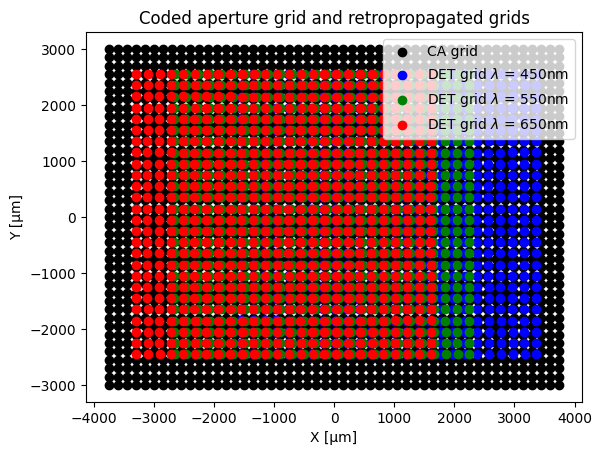

In [7]:
plt.figure()
plt.scatter(cassi_system.X_coded_aper_coordinates[::30,::30].cpu(),cassi_system.Y_coded_aper_coordinates[::30,::30].cpu(),label="CA grid",c="black")
plt.scatter(X_out[::20,::20,0].detach().cpu(),Y_out[::20,::20,0].detach().cpu(),label=f"DET grid $\lambda$ = {int(cassi_system.wavelengths[0])}nm",c="blue")
plt.scatter(X_out[::20,::20,X_out.shape[2]//2].detach().cpu(),Y_out[::20,::20,X_out.shape[2]//2].detach().cpu(),label=f"DET grid $\lambda$ = {int(cassi_system.wavelengths[X_out.shape[2]//2])}nm",c="green")
plt.scatter(X_out[::20,::20,-1].detach().cpu(),Y_out[::20,::20,-1].detach().cpu(),label=f"DET grid $\lambda$ = {int(cassi_system.wavelengths[-1])}nm",c="red")
plt.xlabel("X [µm]")
plt.ylabel("Y [µm]")
plt.legend()
plt.title("Coded aperture grid and retropropagated grids")

In [8]:
min_X_idx, max_X_idx, min_Y_idx, max_Y_idx = cassi_system.find_englobing_indices(X_out, Y_out, cassi_system.X_coded_aper_coordinates, cassi_system.Y_coded_aper_coordinates)

## 4. Input hyperspectral cube preparation <a id="dataset-preparation"></a>


In [8]:
# Load the dataset with specific parameters for augmentation and cropping
dataset = CubesDataset(dataset_dir,cassi_system,augment=augment,crop=crop,crop_size_x=712,crop_size_y=812)

# Load the first cube and its corresponding wavelengths
cube, wavelengths = dataset[0]

151 1022 1354
1 28 812 712


OutOfMemoryError: CUDA out of memory. Tried to allocate 798.00 MiB. GPU 0 has a total capacty of 15.68 GiB of which 284.56 MiB is free. Including non-PyTorch memory, this process has 14.52 GiB memory in use. Of the allocated memory 14.18 GiB is allocated by PyTorch, and 48.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Plot three slices of the data cube for visualization
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(cube[0,0,:,:].detach().cpu())
ax[1].imshow(cube[0,50,:,:].detach().cpu())
ax[2].imshow(cube[0,100,:,:].detach().cpu())
ax[0].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[0])}")
ax[1].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[50])}") 
ax[2].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[100])}")   

## 5. Prepare the filtered cube & pattern <a id="filtering"></a>


In [ ]:
pattern = cassi_system.generate_2D_pattern(config_patterns)
cropped_pattern = pattern[:,min_Y_idx:max_Y_idx,min_X_idx:max_X_idx]

# Repeat the pattern along the wavelengths dimension
cropped_pattern = cropped_pattern.repeat(1, cassi_system.wavelengths.shape[0], 1, 1).to(device)


# Apply the pattern to the interpolated cube
filtered_scene = cube*cropped_pattern

In [ ]:
# Plot three slices of the filtered scene for visualization
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(filtered_scene[0,0,:,:].cpu().numpy())
ax[1].imshow(filtered_scene[0,20,:,:].cpu().numpy())
ax[2].imshow(filtered_scene[0,40,:,:].cpu().numpy())
ax[0].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[0])}")
ax[1].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[20])}") 
ax[2].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[40])}")   

In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 6. Interpolation + convolution <a id="magic"></a>


In [ ]:
# Normalize the coordinates of the retropropagated grid in relation to the maximum CA grid coordinates
x_propagated_ca_grid = X_out.unsqueeze(0) / cassi_system.X_coded_aper_coordinates.max()
y_propagated_ca_grid = Y_out.unsqueeze(0) / cassi_system.Y_coded_aper_coordinates.max()

# Create a grid with the normalized coordinates
grid = torch.stack([y_propagated_ca_grid,x_propagated_ca_grid], dim=0).to(device)
grid = grid.permute(1, 4, 2, 3, 0)

In [ ]:
# Initialize the interpolation layer with specific kernel size and sigma
interpolation_layer = FastInterpolateWithKernel(kernel_size=11, sigma=5,device=device)
acquisition3D = interpolation_layer(filtered_scene.contiguous(), grid.contiguous(),chunk_size=1)

In [ ]:

# Plot three slices of the 3D acquisition for visualization
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(acquisition3D[0,0,:,:].cpu().numpy())
ax[1].imshow(acquisition3D[0,20,:,:].cpu().numpy())
ax[2].imshow(acquisition3D[0,40,:,:].cpu().numpy())
ax[0].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[0])}")
ax[1].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[20])}") 
ax[2].set_title(f"cube slice for wavelength {int(cassi_system.wavelengths[40])}")   

## 7. Acquisition <a id="acquisition"></a>


In [ ]:
# Sum the acquisition along a specific dimension
acquisition = acquisition3D.sum(dim=1)

In [ ]:

# Plot the final acquisition image
plt.figure()
plt.imshow(acquisition[0,:,:].cpu().numpy())
plt.title("Acquisition image")